# Задачи, цели работы


## Цель работы


Цель данной лабораторной работы заключается в изучении и реализации методов высокого порядка для решения задач оптимизации, таких как Gauss-Newton, Dog Leg, BFGS.

## Задачи для достижения указанной цели

1. Реализация методов Gauss-Newton и Powell Dog Leg для решения нелинейной регрессии. Сравнение их эффективности с методами, реализованными в предыдущих работах.
2. Реализация метода BFGS для минимизации различных функций. Исследование его сходимости и сравнение с другими реализованными методами.
3. Реализация и исследование метода L-BFGS, аналогично методу BFGS.
4. Подготовка отчёта, содержащего описание реализованных методов, тесты, таблицы и графики для демонстрации результатов.

# Ход работы

## Подготовка среды, определение полезных функций

### В предыдущих сериях:

In [2]:
import numpy as np
import profiler
import descent
import regression
import visualization
import dataset

### Non-Linear regression function

In [3]:
# Demo

### Learning rate scheduling + Adam

Всего точек: 50001
Минимум в  [1.4635995486411844 5.6265329139060825]
Значение функции в точке минимума:  22.810803621844972


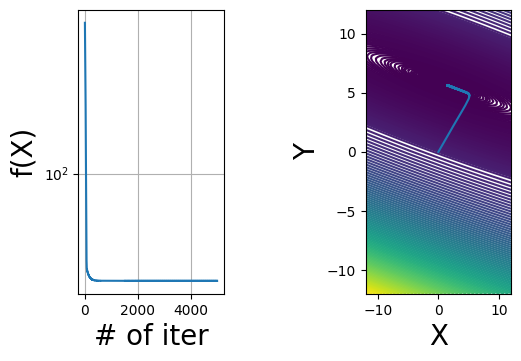

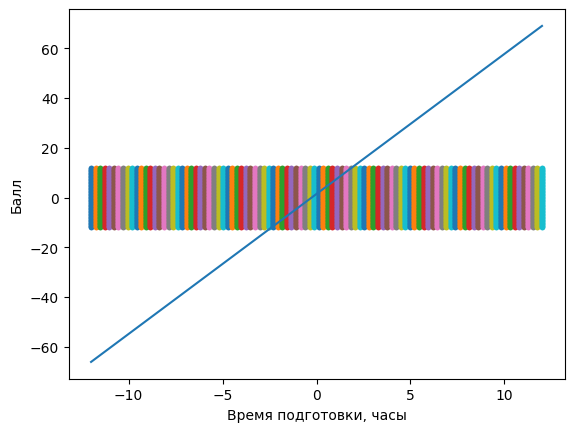

In [4]:
f, f_chunk = dataset.get_linear_loss_func(*dataset.get_data())
visualization.linear_demo_2args(descent.adam_minibatch_descent(f=f_chunk, df=descent.numeric_gradient, x0=np.array([0.0, 0.0]), decay=descent.constant_lr_decay(1e-2), n_epochs=1000, batch_size=2, tol=0.001), f)

### Gauss-Newton

In [5]:
# Demo

### Powell Dog Leg

In [6]:
# Demo

### Выводы

// текстовый вывод


## Задание 2. Исследование метода BFGS


Метод является идеологическим продолжением квазиньютоновских методов ...

### Квадратичная функция

In [21]:
from funcs import f_matias
from bfgs import bfgs

import descent

bfgs(f_matias, descent.numeric_gradient, x_0=np.array((5.0, 5.0)), epochs=1000)

(array([-6.81298249e-06, -6.81298524e-06]), 100)

// Демонстрация + наложенная траектория прошлых методов

### Линейная регрессия

// Демонстрация + наложенная траектория прошлых методов

### Нелинейная регрессия

// Демонстрация + наложенная траектория прошлых методов

### // ?????

// Демонстрация + наложенная траектория прошлых методов

### Выводы


Текстовый вывод

# Бонусное задание

## Задание 1. Реализация метода L-BFGS

### Квадратичная функция

In [23]:
from funcs import f_matias
from bfgs import l_bfgs

import descent

l_bfgs(f_matias, descent.numeric_gradient, x_0=np.array((1.0, 1.0)), tol=1e-9, epochs=1000, m=100)

(array([-2.86348369e-11,  2.86283405e-11]), 200)

// Демонстрация + наложенная траектория прошлых методов

### Линейная регрессия

// Демонстрация + наложенная траектория прошлых методов

### Нелинейная регрессия

// Демонстрация + наложенная траектория прошлых методов

### // ?????

// Демонстрация + наложенная траектория прошлых методов

### Выводы


Текстовый вывод

# Заключение



## Сравнительный анализ приведённых методов

### Графики

// Наложенные траектории и восстановленные регрессии

### Использование ресурсов

// Таблица от профайлера

## Вывод

// Текстовый финал.